In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
def run_execute(q):
    with sqlite3.connect('chinook.db')as conn:
        conn.isolation_level = None
        conn.execute(q)
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [2]:
q = '''
with it as(
SELECT 
    t.*,
    SUM(i.quantity) quantity
    from track t
    inner join invoice_line i on i.track_id = t.track_id
    group by t.genre_id
    )
select
    g.name,
    it.quantity,
    cast(it.quantity as float)/(select sum(quantity) from invoice_line) percentage
    from it
    left join genre g on g.genre_id = it.genre_id;
'''
run_query(q)


,name,quantity,percentage
0,Rock,2635,0.553921
1,Jazz,121,0.025436
2,Metal,619,0.130124
3,Alternative & Punk,492,0.103427
4,Blues,124,0.026067
5,Latin,167,0.035106
6,Reggae,35,0.007358
7,Pop,63,0.013244
8,Soundtrack,5,0.001051
9,Easy Listening,74,0.015556


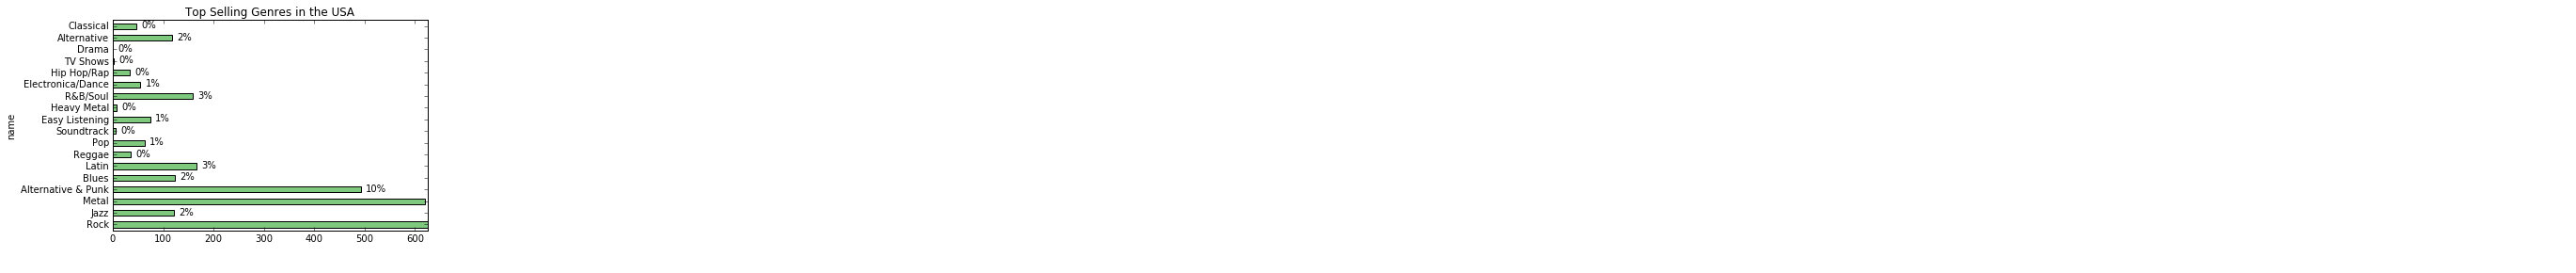

In [3]:
genre_sales_usa = run_query(q)
genre_sales_usa.set_index("name", inplace=True, drop=True)

genre_sales_usa["quantity"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)
for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "quantity"]
    label = (genre_sales_usa.loc[label, "percentage"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

In [4]:
q1 = '''
with it as(
    select t.*,
        sum(il.quantity) total
        from track t
        inner join invoice_line il on il.track_id = t.track_id
        inner join album a on a.album_id = t.album_id
        group by t.album_id
        order by total desc
)
select 
    a.title album,
    g.name
    from it
    inner join genre g on g.genre_id = it.genre_id
    inner join album a on a.album_id = it.album_id
    limit 3
'''
d1 = run_query(q1)
d1

,album,name
0,Are You Experienced?,Rock
1,Faceless,Metal
2,Mezmerize,Metal


In [5]:
q2 = '''
    select 
        e.first_name||" "||e.last_name employee,
        e.hire_date,
        sum(i.total) amount
    from employee e
    left join customer c on c.support_rep_id = e.employee_id
    inner join invoice i on i.customer_id = c.customer_id
    group by e.employee_id
    order by e.employee_id
'''
employee_sales = run_query(q2)
employee_sales

,employee,hire_date,amount
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


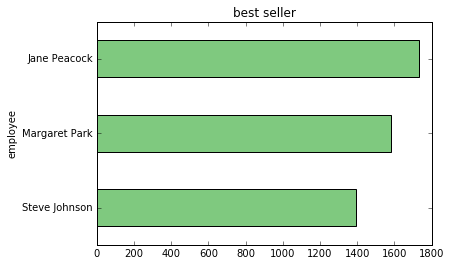

In [6]:
employee_sales.set_index("employee", drop=True, inplace=True)
employee_sales.sort_values("amount", inplace=True)
employee_sales.plot.barh(
    legend = False,
    title = "best seller",
    colormap =plt.cm.Accent)
plt.show()

In [62]:
q3 = '''
WITH co AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       i.*
     FROM invoice i
     INNER JOIN customer c ON c.customer_id = i.customer_id
    ),
  cal AS
  (
      SELECT
        co.country,
        SUM(distinct co.customer_id) num_of_customer,
        SUM(co.total) total_sales,
        SUM(co.total)/count(distinct co.customer_id) value_per_customer,
        SUM(co.total)/count(distinct co.invoice_id) value_per_order
        FROM co
        GROUP BY co.country
  )
  SELECT
      country,
      num_of_customer,
      total_sales,
      value_per_customer,
      value_per_order
      FROM 
      (
          SELECT
          cal.*,
          CASE
            WHEN country = "Other" THEN 1
            ELSE 0
            END AS sort
            FROM cal
      )
     ORDER BY sort ASC, total_sales desc
      
        
'''
run_query(q3)

,country,num_of_customer,total_sales,value_per_customer,value_per_order
0,USA,286,1040.49,80.037692,7.942672
1,Canada,187,535.59,66.948750,7.047237
2,Brazil,47,427.68,85.536000,7.011148
3,France,205,389.07,77.814000,7.781400
4,Germany,113,334.62,83.655000,8.161463
5,Czech Republic,11,273.24,136.620000,9.108000
6,United Kingdom,159,245.52,81.840000,8.768571
7,Portugal,69,185.13,92.565000,6.383793
8,India,117,183.15,91.575000,8.721429
9,Other,576,1094.94,72.996000,7.448571


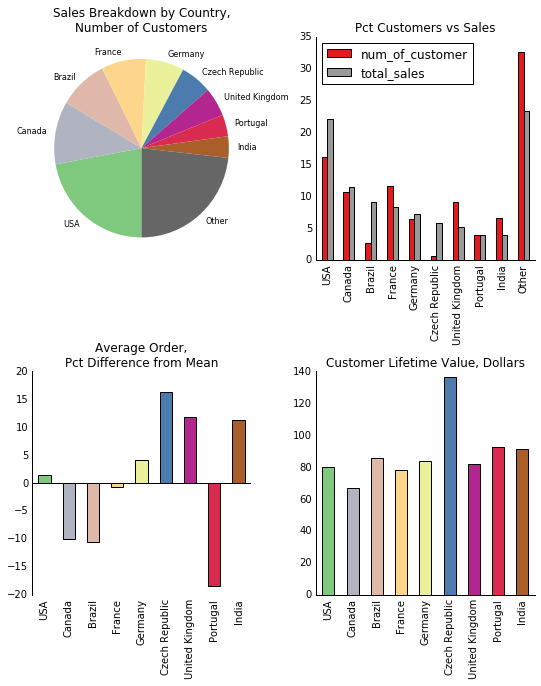

In [69]:
import numpy as np
country_metrics = run_query(q3)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)
# top right
cvd_cols = ["num_of_customer","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# bottom left
avg_order = country_metrics["value_per_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["value_per_customer"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

In [76]:
q4 = '''
WITH ifs AS(
    SELECT
        il.invoice_id,
        min(il.track_id) first_id
    FROM invoice_line il
    GROUP BY 1
)
SELECT
    album_purchased,
    count(invoice_id) num_of_invoice,
    CAST(count(invoice_id) as FLOAT)/(SELECT COUNT(*) FROM invoice) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                (SELECT t.track_id FROM track t
                    WHERE t.album_id = (SELECT t2.album_id from track t2
                                            WHERE t2.track_id = ifs.first_id)
                EXCEPT
                
                SELECT il2.track_id from invoice_line il2
                    WHERE il2.invoice_id = ifs.invoice_id)IS NULL
            AND
            (
             SELECT il2.track_id from invoice_line il2
                    WHERE il2.invoice_id = ifs.invoice_id
                EXCEPT
                SELECT t.track_id FROM track t
                    WHERE t.album_id = (SELECT t2.album_id from track t2
                                            WHERE t2.track_id = ifs.first_id)
                )IS NULL
                THEN "yes"
                ELSE "no"
                END AS album_purchased
    FROM ifs)
    GROUP BY 1;
'''
run_query(q4)

,album_purchased,num_of_invoice,percent
0,no,500,0.814332
1,yes,114,0.185668
